In [112]:
import os
import numpy as np
import matplotlib.pyplot as plt
import re
from pathlib import Path
import shutil
import tifffile
import cv2
import math
from napari_correct_drift import CorrectDrift
from skimage import filters

# MM3 req 1: Channels are mostly vertical
# MM3 Req 2: Channels have at least 20 pixels from their ends to the top and bottom edge of the image
Channel ends are in the top and bottom third of the image, regardless of orientation.
There are no artefacts in the image above and below the channels. The numbers on the mother machine can confuse the script.

In [113]:
root_dir = '/Users/nvivanco/Desktop/20240919/dimm_giTG66_glucose_1'
unstacked_path = napari_ready_format_drift_correct(root_dir, 'dimm', c = 0)

Applying drift: 100%|█████████████████████████| 137/137 [00:16<00:00,  8.17it/s]


In [122]:
unstacked_path = '/Users/nvivanco/Desktop/20240919/dimm_giTG66_glucose_1/hyperstacked/drift_corrected/cyx_files_for_mm3/xy001'

Lines identified in FOV 001
Horizontal lines


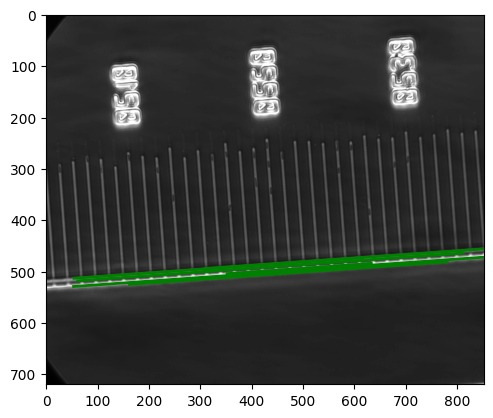

Vertical lines


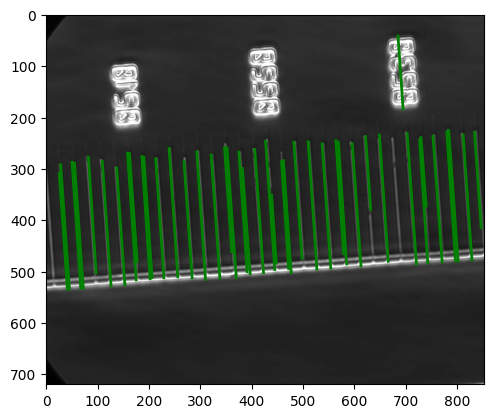

In [123]:
plot_lines_across_FOVs(unstacked_path, c = 0)

/Users/nvivanco/Desktop/20240919/dimm_giTG66_glucose_1/hyperstacked/drift_corrected/cyx_files_for_mm3/xy001/drift_cor_dimm_t0000xy001.tif
Using vertical lines to find rotation angle
-3.9922908821527727
Longest line detected in image
Cropping reference image
Lines identified in FOV 001


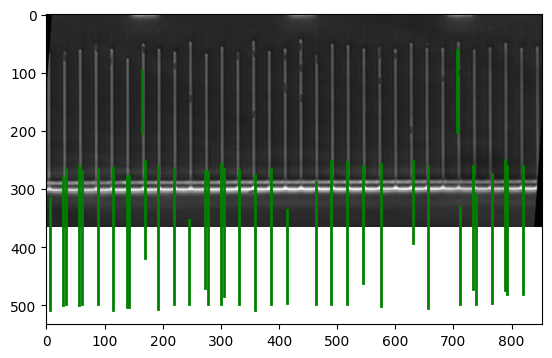

Successfully rotated stack


In [126]:
rotate_stack(unstacked_path, c = 0, orientation = 'vertical', vertical_pad = 60)

# Functions for pre-processing mother machine images

In [108]:
def detect_clear_image(image):
    laplacian_image = filters.laplace(image)
    blur_score = np.var(laplacian_image)
    if blur_score >= 0:
        return True

In [125]:
def napari_ready_format_drift_correct(root_dir, experiment_name, c = 0):
    """ 
    Arg
    root_dir: parent directory containing multiple 'Pos#' directories, 
    each containing tif files of single timepoints and channels of the given position. 
    File name is default from the Covert lab microscope.
    experiment_name: unique id to label output files
    c = int representing phase channel index
    output: drift corrected files across multiple positions and timepoints. Found within
    'cyx_files_for_mm3' directory
    
    """

    hyperstacked_path = os.path.join(root_dir, 'hyperstacked')
    drift_corrected_path = os.path.join(hyperstacked_path, 'drift_corrected')
    output_dir_path = os.path.join(drift_corrected_path, 'cyx_files_for_mm3')

    time_dict = hyperstack_tif_tcyx(root_dir, experiment_name)
    
    drift_correction_napari(hyperstacked_path)
    
    unstack_tcyx_to_cyx(drift_corrected_path, time_dict)
    
    return output_dir_path

def hyperstack_tif_tcyx(root_dir, experiment_name, c = 0):
    
    """Renames TIFF files without deleting originals.
    Args:
    input_dir: parent directory.
    experiment_name: The desired experiment name.
    """
    root = Path(root_dir)
    input_dirs = [str(path) for path in root.glob('**//Pos*') if path.is_dir()]

    # Create output directory if it doesn't exist
    output_dir_path = os.path.join(root_dir, 'renamed')
    os.makedirs(output_dir_path, exist_ok=True)
    stacked_path = os.path.join(root_dir, 'stacked')
    os.makedirs(stacked_path, exist_ok=True)
    hyperstacked_path = os.path.join(root_dir, 'hyperstacked')
    os.makedirs(hyperstacked_path, exist_ok=True)

    time_clear_dict = {}

    file_groups = org_by_timepoint(input_dirs)
    for position, time in sorted(file_groups.items()):
        time_clear_dict[position] ={}
        time_stacked_image_data = []
        for time, channels in sorted(time.items()):
            image_data = []
            for channel, image_path in sorted(channels.items()):
                new_filename = f'{experiment_name}_t{time:04.0f}xy{position}c{channel}.tif'
                new_path = os.path.join(output_dir_path, new_filename)
                try:
                    # Copy the file to the new path
                    shutil.copy(str(image_path), str(new_path))
                    channel_image = tifffile.TiffFile(new_path).asarray() 
                    image_data.append(channel_image)
                    
                except OSError as e:
                    print(f'Error copying file: {e}')
            stacked_image = np.stack(image_data, axis=0)  # Assuming channels are the first dimension
            output_stacked_file = Path(stacked_path) / f"{experiment_name}_t{time:04.0f}xy{position}.tif"
            tifffile.imwrite(str(output_stacked_file), stacked_image)
            phase_image = stacked_image[c, :, :]
            if detect_clear_image(phase_image): # only time stack clear images
                time_stacked_image_data.append(stacked_image) 
                time_clear_dict[position][time] = 'clear'
            else:
                time_clear_dict[position][time] = 'blurry'
                print('blurry')
        hyperstacked_image = np.stack(time_stacked_image_data, axis=0)  # time as the first dimension
        output_hyperstacked_file = Path(hyperstacked_path) / f"{experiment_name}_xy{position}.tif"
        tifffile.imwrite(str(output_hyperstacked_file), hyperstacked_image)
        
    return time_clear_dict

def drift_correction_napari(hyperstacked_path):
    output_dir_path = os.path.join(hyperstacked_path, 'drift_corrected')
    os.makedirs(output_dir_path, exist_ok=True)
    
    for filename in os.listdir(hyperstacked_path):
        if filename.endswith('.tif') or filename.endswith('.tiff'):
            if re.match(r'(.*)_xy(\d+)\.' ,filename):
                match = re.match(r'(.*)_xy(\d+)\.' ,filename)
                experiment, position = match.groups()
                img_path = os.path.join(hyperstacked_path, filename)
                hyperstacked_img = tifffile.imread(img_path)
                # multi-channel 2D-movie
                cd = CorrectDrift(hyperstacked_img, "tcyx")
                # estimate drift table
                drifts = cd.estimate_drift(t0=0, channel=0)
                # correct drift
                img_cor = cd.apply_drifts(drifts)
                img_cor_file = Path(output_dir_path) / f"drift_cor_{experiment}_xy{position}.tif"
                tifffile.imwrite(str(img_cor_file), img_cor)

def org_by_timepoint(input_dirs):
    
    """Group files by time and channel id, it does not take into account the z axis
    Reads in files in the format exported by the Covert lab scope, 
    which is as follows: 'img_channel(\d+)_position(\d+)_time(\d+)_z(\d+)\.'

    Returns a dictionary in the following format:
    dict[time_frame] = {channel_id : '/path/to/tif/file'}
    """

    time = 'hyperstacked'
    channel = 'stacked'
    position = '0'
    
    file_groups = {}
    
    for input_dir in input_dirs:
        for filename in os.listdir(input_dir):
            if filename.endswith('.tif') or filename.endswith('.tiff'):
                match = re.match(r'img_channel(\d+)_position(\d+)_time(\d+)_z(\d+)\.' ,filename)
                if match:
                  channel, position, time, z = match.groups()
                  time = int(time)
                elif re.match(r'(.*)_t(\d+)xy(\d+)\.',filename):
                    match = re.match(r'(.*)_t(\d+)xy(\d+)\.',filename)
                    experiment, time, position = match.groups()
                    time = int(time)
                else:
                    match = re.match(r'(.*)_xy(\d+)\.' ,filename)
                    if match:
                        experiment, position = match.groups()
                path = os.path.join(input_dir, filename)
                if position not in file_groups:
                  file_groups[position] = {}
                if time not in file_groups[position]:
                  file_groups[position][time] = {}
                if channel not in file_groups[position][time]:
                  file_groups[position][time][channel] = path
    
    return file_groups

def unstack_tcyx_to_cyx(path_to_hyperstacked, time_clear_dict):
    
    """
    input_dir: directory where movies are hyperstacked as tcyx
    output_dir: The output directory for TIFF files stacked as cyx
    """

    # Create output directory if it doesn't exist
    output_dir_path = os.path.join(path_to_hyperstacked, 'cyx_files_for_mm3')
    os.makedirs(output_dir_path, exist_ok=True)
    

    file_groups = org_by_timepoint([path_to_hyperstacked])
    for position, time in sorted(file_groups.items()):
        for time, channels in sorted(time.items()):
            for channel, image_path in sorted(channels.items()):
                filename = os.path.basename(image_path)
                match = re.match(r'(.*)_xy(\d+)\.' ,filename)
                if match:
                    experiment, position = match.groups()
                    hyperstacked_img = tifffile.imread(image_path)
                    real_times = [key for key, val in time_clear_dict[position].items() if val == 'clear']
                    index_times = [i for i in range(0, hyperstacked_img.shape[0], 1)]
                    index_to_real_time = dict(zip(index_times, real_times))
    
                    for index in range(hyperstacked_img.shape[0]):
                        cyx_image = hyperstacked_img[index, :, :, :]
                        real_time = index_to_real_time[index]
                        output_cyx_file = Path(output_dir_path) / f"{experiment}_t{real_time:04.0f}xy{position}.tif"
                        tifffile.imwrite(str(output_cyx_file), cyx_image)
                        

def plot_lines_across_FOVs(path_to_stack, c = 0):
    
    """Args:
    path_to_stack: Path to stack of cyx format files, in string format
    c: Phase channel index in integer format, default = 0
    Output is a series of plotted images with identified 
    horizontal or vertical lines across FOVs/positions
    """
    file_groups = org_by_timepoint([path_to_stack])

    for position in file_groups.keys():
        earliest_timepoint = min(file_groups[position].keys())
        first_file_path = file_groups[position][earliest_timepoint]['stacked']
        ref_img = tifffile.imread(first_file_path)
        ref_phase_img = ref_img[c, :, :]
        horizontal_lines, vertical_lines = id_lines(ref_phase_img)
        print('Lines identified in FOV ' + position)
        print('Horizontal lines')
        plot_lines(ref_phase_img, horizontal_lines)
        print('Vertical lines')
        plot_lines(ref_phase_img, vertical_lines)

def rotate_stack(path_to_stack, c = 0, orientation = 'vertical', vertical_pad = 50, growth_channel_length = 150):
    """Args:
    path_to_stack: Path to stack of cyx format files, in string format
    c: Phase channel index in integer format, default = 0
    orientation: Orientation of lines to use to rotate and crop files, 
    value is a string indicating "horizontal" or "vertical". Defualt is vertical.
    growth_channel_length: length in pixels of growth channel. 
    Shorter channels are approx 130 pixels. 150 is default.
    """
    #create an output directory for the rotated files
    path_to_rotated_images = os.path.join(path_to_stack, 'rotated')
    os.makedirs(path_to_rotated_images, exist_ok=True)

    file_groups = org_by_timepoint([path_to_stack])

    for position in file_groups.keys():
        earliest_timepoint = min(file_groups[position].keys())
        first_file_path = file_groups[position][earliest_timepoint]['stacked']
        print(first_file_path)
        ref_img = tifffile.imread(first_file_path)
        ref_phase_img = ref_img[c, :, :]
        h, w = ref_phase_img.shape
        horizontal_lines, vertical_lines = id_lines(ref_phase_img)
        crop_start = 0
        crop_end = h
        rotation_angle = 0

        if orientation == 'vertical':
            print('Using vertical lines to find rotation angle')
            rotation_angle = calculate_rotation_angle(ref_phase_img, vertical_lines) - 90
            print (rotation_angle)
            ref_rotated_image = apply_image_rotation(ref_phase_img, rotation_angle)
            rot_horizontal_lines, rot_vertical_lines = id_lines(ref_rotated_image)
            crop_start, crop_end = crop_around_growth_channel(rot_vertical_lines, h, padding=vertical_pad)
            ref_cropped_img = ref_rotated_image[crop_start:crop_end, :] 
            print('Lines identified in FOV ' + position)
            plot_lines(ref_cropped_img, rot_vertical_lines)
        
        elif orientation == 'horizontal':
            print('Using horizontal lines to find rotation angle')
            rotation_angle = calculate_rotation_angle(ref_phase_img, horizontal_lines)
            ref_rotated_image = apply_image_rotation(ref_phase_img, rotation_angle)
            rot_horizontal_lines, rot_vertical_lines = id_lines(ref_rotated_image)
            crop_start, crop_end = crop_around_central_flow(rot_horizontal_lines, h, growth_channel_length)
            ref_cropped_img = ref_rotated_image[crop_start:crop_end, :]
            print('Lines identified in FOV ' + position)
            plot_lines(ref_cropped_img, rot_horizontal_lines)
        
        else:
            print('Orientation of image was not recognized')
            return None
        
        #apply rotation and crop to all other images in path
        for time in file_groups[position]:
            path = file_groups[position][time]['stacked']
            time_img = tifffile.imread(path)
            rotated_image = apply_image_rotation(time_img, rotation_angle)
            cropped_img = rotated_image[:, crop_start:crop_end, :]
            filename = os.path.basename(path)
            new_filename = f'rotated_{filename}'
            new_path = os.path.join(path_to_rotated_images, new_filename)
            tifffile.imwrite(new_path, cropped_img)
        print('Successfully rotated stack')

def calculate_line_angle(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    angle = np.arctan2(dy, dx) * 180 / np.pi
    return angle

def find_lines(img):
    normalized_img = (img / img.max() * 255).astype(np.uint8)
    edges = cv2.Canny(normalized_img, 50, 150)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=100, maxLineGap=10)
    return lines
    
def id_lines(img):
    lines = find_lines(img)
    h_lines = []
    v_lines = []
    count = 0
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            angle = calculate_line_angle(x1, y1, x2, y2)
            if abs(angle) < 30:  # Adjust threshold as needed
                h_lines.append(line)
                count+= 1
            elif 60 <= abs(angle) <= 120:  # Adjust threshold as needed
                v_lines.append(line)
                count+= 1
            if count >= 50:
                break
    return h_lines, v_lines


def calculate_rotation_angle(img, lines):
    """calculate rotation angle based on phase image"""
    angles = []
    for line in lines:
        # Calculate angle of the line
        x1, y1, x2, y2 = line[0]
        angle = calculate_line_angle(x1, y1, x2, y2)
        angles.append(abs(angle))
    average_angle = sum(angles) / len(angles)
    return average_angle

def plot_lines(original_img, lines):
    plt.figure()
    plt.imshow(original_img, cmap='gray')
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            plt.plot([x1, x2], [y1, y2], color='green', linewidth=2) 
        plt.show()

def crop_around_central_flow(h_lines, h, growth_channel_length= 150):
    if h_lines is not None:
        x1, y1, x2, y2 = h_lines[0][0]

        # Determine crop boundaries
        crop_start = max(y2 - growth_channel_length, 0)
        crop_end = min(y1 + growth_channel_length, h)

        print('Cropping reference image')

        return crop_start, crop_end

    else:
        print('Warning: horizontal lines were not detected')
        return None

def crop_around_growth_channel(v_lines, h, padding=50):
    if v_lines is not None:
        longest_line = [max(v_lines, key=lambda line: np.sqrt((line[0][2] - line[0][0])**2 + (line[0][3] - line[0][1])**2))]
        print('Longest line detected in image')
        x1, y1, x2, y2 = longest_line[0][0]

        # Determine crop boundaries
        crop_start = max(y2 - padding, 0)
        crop_end = min(y1 + padding, h)

        print('Cropping reference image')

        return crop_start, crop_end

    else:
        print('Warning: vertical lines were not detected')
        return None

def apply_image_rotation(image_stack, rotation_angle):
    """Applies rotation to an image stacked as cyx.

    Args:
        image: image in Grey or BGR format for OpenCV 
        rotation_angle: The rotation angle in degrees.

    Returns:
        Rotated image in BGR format.
    """
    rotated_stack = np.zeros_like(image_stack)
    h = None
    w = None
    if image_stack.ndim == 3:
        h, w = image_stack.shape[1:]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)
        for i in range(image_stack.shape[0]):
            rotated_stack[i] = cv2.warpAffine(image_stack[i], M, (w, h))
    
    elif image_stack.ndim == 2:
        h, w = image_stack.shape
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)
        rotated_stack = cv2.warpAffine(image_stack, M, (w, h))

    return rotated_stack